In [2]:
#Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [34]:
#Save the data set and analyze it
df_spx = pd.read_csv('sample_data/SPX.csv')

print(df_spx.shape)
print(df_spx.columns)
print(df_spx.dtypes)
print(df_spx.head(3))

print(df_spx.isnull().sum())
print(df_spx.isna().sum())
print(df_spx.count())
print(df_spx.describe())

#We found that:
# 1. We dont have missing data for any column
# 2. We have to change the datatype of the Date column to datetime since it is object
# 3. We have to check the difference between each pair of data of the Date column
# 4. We have to select the Date column as index

(23323, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
         Date       Open       High        Low      Close  Adj Close  Volume
0  1927-12-30  17.660000  17.660000  17.660000  17.660000  17.660000       0
1  1928-01-03  17.760000  17.760000  17.760000  17.760000  17.760000       0
2  1928-01-04  17.719999  17.719999  17.719999  17.719999  17.719999       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date         23323
Open         23323
High         23323
Low          23323
Close        23323
Adj Close    23323
Volume       23323
dtype: int64
               Open          High           Low    

In [35]:
#Now we check that the difference between each pair of data is the same

df_spx = df_spx.set_index('Date')
df_spx.index = pd.to_datetime(df_spx.index)
print(df_spx.dtypes)

df_time_diffs = df_spx.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

#We can see we have differences in the timestamp between pairs of data

#The values are indicated in seconds:
#   *86400 seconds - 24 hrs - 1 day
#   *259200 seconds - 72 hrs - 3 days
#   *345600 seconds - 96 hrs - 4 days

#We have to standarize to have the same timestamp (1 day)


Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
Date
86400.0      18127
259200.0      4313
345600.0       522
172800.0       350
432000.0         8
1036800.0        1
604800.0         1
Name: count, dtype: int64


In [37]:
df_spx_day = df_spx.asfreq(freq='D',method='bfill')
df_time_diffs = df_spx_day.index.to_series().diff().dt.total_seconds()
print(df_time_diffs.value_counts())

#Now we see we have the same timestamp (1 day) between samples


Date
86400.0    33913
Name: count, dtype: int64


In [39]:
#We are going to check that we dont affect the data analyzing the average of the original and the new dataset

print(df_spx.describe)
print(df_spx_day.describe)

print(df_spx_day.info())

<bound method NDFrame.describe of                    Open         High          Low        Close    Adj Close  \
Date                                                                          
1927-12-30    17.660000    17.660000    17.660000    17.660000    17.660000   
1928-01-03    17.760000    17.760000    17.760000    17.760000    17.760000   
1928-01-04    17.719999    17.719999    17.719999    17.719999    17.719999   
1928-01-05    17.549999    17.549999    17.549999    17.549999    17.549999   
1928-01-06    17.660000    17.660000    17.660000    17.660000    17.660000   
...                 ...          ...          ...          ...          ...   
2020-10-29  3277.169922  3341.050049  3259.820068  3310.110107  3310.110107   
2020-10-30  3293.590088  3304.929932  3233.939941  3269.959961  3269.959961   
2020-11-02  3296.199951  3330.139893  3279.739990  3310.239990  3310.239990   
2020-11-03  3336.250000  3389.489990  3336.250000  3369.159912  3369.159912   
2020-11-04  3406.4

In [42]:
#We are going to use the Close column as reference to train the model, so we can delete the other columns

keep = ['Close']
df_reduced = df_spx_day[keep]
df_reduced.head(10)


,Close
Date,
1927-12-30,17.660000
1927-12-31,17.760000
1928-01-01,17.760000
1928-01-02,17.760000
1928-01-03,17.760000
1928-01-04,17.719999
1928-01-05,17.549999
1928-01-06,17.660000
1928-01-07,17.500000


<Figure size 1000x600 with 0 Axes>

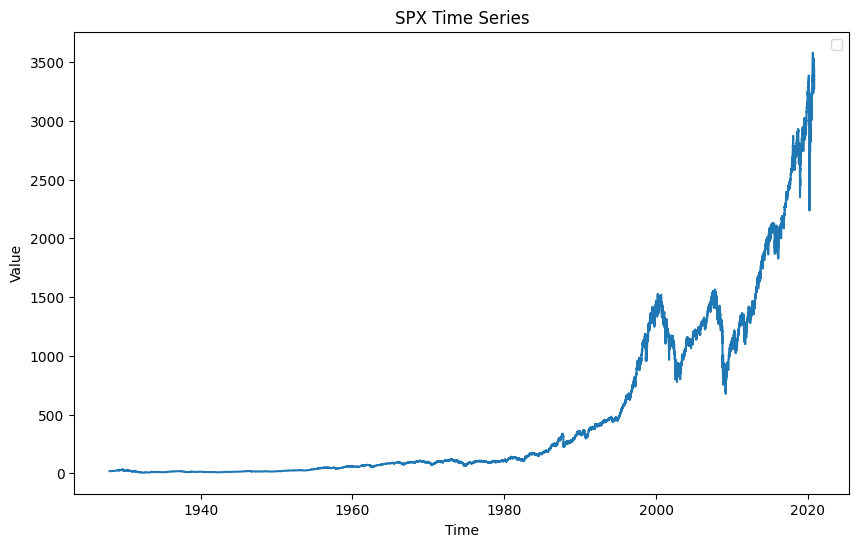

In [43]:
#Create the figure
plt.figure(figsize=(10, 6))

#Graph the data filtered
plt.figure(figsize=(10, 6))
plt.plot(df_reduced)

#Customize the graph
plt.title('SPX Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

#Show the figure
plt.show()

<Figure size 1000x600 with 0 Axes>

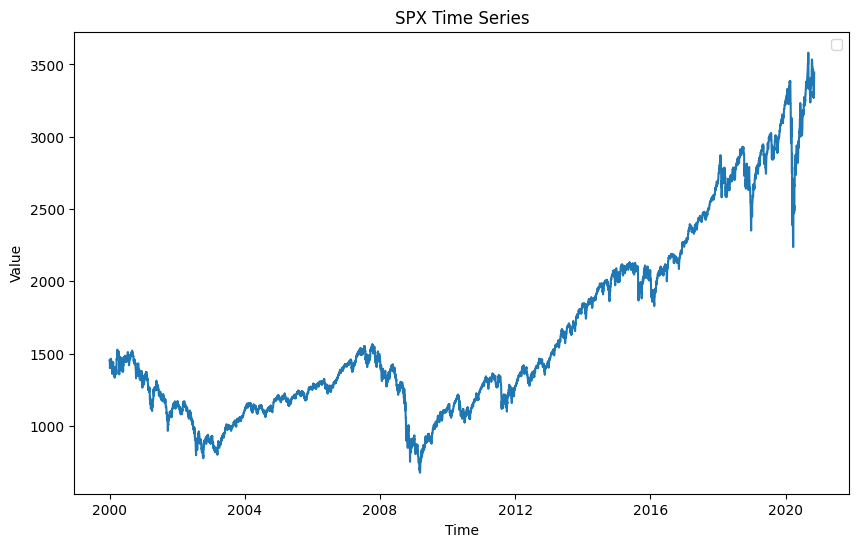

In [46]:
#We are going to make the analysis starting from 2000
df_analysis = df_reduced['2000':]

#Create the figure
plt.figure(figsize=(10, 6))

#Graph the data filtered
plt.figure(figsize=(10, 6))
plt.plot(df_analysis)

#Customize the graph
plt.title('SPX Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

#Show the figure
plt.show()

In [51]:
#We are going to divide all the time series into training, validation and testing

set_training = df_analysis['2000':'2015']
set_validation = df_analysis['2016':'2018']
set_testing = df_analysis['2019':]

<Figure size 1000x600 with 0 Axes>

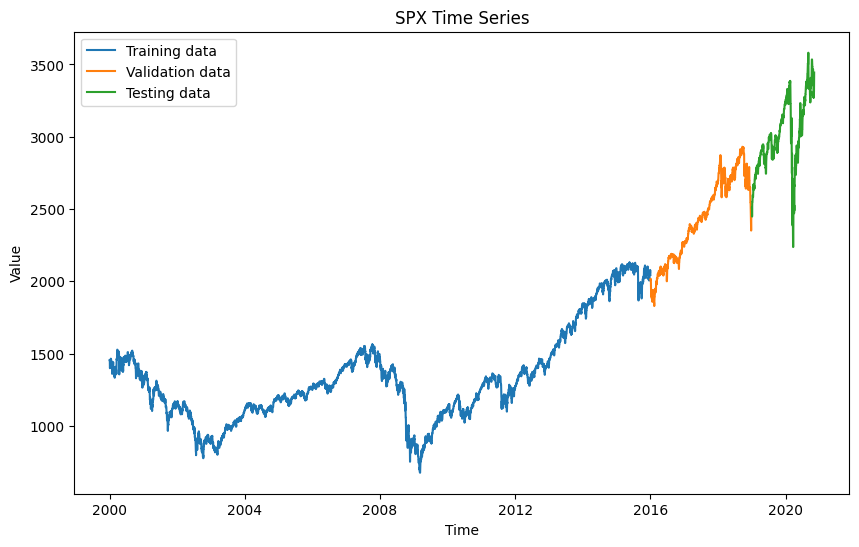

In [52]:
#Create the figure
plt.figure(figsize=(10, 6))


#Graph the data filtered
plt.figure(figsize=(10, 6))
plt.plot(set_training, label = 'Training data')
plt.plot(set_validation, label = 'Validation data')
plt.plot(set_testing, label = 'Testing data')

#Customize the graph
plt.title('SPX Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

#Show the figure
plt.show()

In [53]:
#Check the shapes of the dataframes

print(set_training.shape)
print(set_validation.shape)
print(set_testing.shape)

(5844, 1)
(1096, 1)
(674, 1)


In [54]:
#Normalize the datasets

#Normalization and creation of sets scaled
sc = MinMaxScaler(feature_range=(0,1))
set_training_scaled = sc.fit_transform(set_training)
set_validation_scaled = sc.fit_transform(set_validation)
set_testing_scaled = sc.fit_transform(set_testing)

In [55]:
time_step = 45
X_train = []
Y_train = []

#Loop to add to X_train lists of 45 values and lists of 1 value to Y_train
for i in range(time_step,len(set_training_scaled)):
    X_train.append(set_training_scaled[i-time_step:i,0])
    Y_train.append(set_training_scaled[i,0])

#Convert the lists to np arrays
X_train, Y_train = np.array(X_train), np.array(Y_train)

#Reshape X_train to the form (samples,45,1)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
#print(X_train)


(5799, 45, 1)


In [56]:
time_step = 45
X_validation = []
Y_validation = []

#Loop to add to X_validation lists of 45 values and lists of 1 value to Y_validation
for i in range(time_step,len(set_validation_scaled)):
    X_validation.append(set_validation_scaled[i-time_step:i,0])
    Y_validation.append(set_validation_scaled[i,0])

#Convert the lists to np arrays
X_validation, Y_validation = np.array(X_validation), np.array(Y_validation)

#Reshape X_validation to the form (samples,45,1)
X_validation = np.reshape(X_validation, (X_validation.shape[0],X_validation.shape[1],1))
print(X_validation.shape)

(1051, 45, 1)


In [57]:
time_step = 45
X_test = []
Y_test = []

#Loop to add to X_test lists of 45 values and lists of 1 value to Y_test
for i in range(time_step,len(set_testing)):
    X_test.append(set_testing_scaled[i-time_step:i,0])
    Y_test.append(set_testing_scaled[i,0])

#Convert the lists to np arrays
X_test, Y_test = np.array(X_test), np.array(Y_test)

#Reshape X_train to the form (samples,45,1)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)

(629, 45, 1)


In [58]:
#Input form: (samples,45,1)
inputs = Input(shape=(X_train.shape[1], 1))

#Number of neurons for the LSTM layer
na=100

lstm_layer = LSTM(na, return_sequences=False)(inputs)

dense_hidden1 = Dense(64, activation='relu')(lstm_layer)
dense_hidden2 = Dense(32, activation='relu')(dense_hidden1)
dense_hidden3 = Dense(16, activation='relu')(dense_hidden2)
dense_hidden4 = Dense(16, activation='relu')(dense_hidden3)
output = Dense(1)(dense_hidden4)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mse')

In [59]:
#Train of the model including validation data
history = model.fit(X_train,Y_train,epochs=20,batch_size=32,validation_data=(X_validation, Y_validation))

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0398 - val_loss: 0.0011
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 2.7813e-04 - val_loss: 8.7924e-04
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 2.6344e-04 - val_loss: 6.8105e-04
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 2.0646e-04 - val_loss: 6.2901e-04
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 1.7705e-04 - val_loss: 5.8578e-04
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 1.7177e-04 - val_loss: 4.8968e-04
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 1.5778e-04 - val_loss: 5.1081e-04
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 1.4825e-04 - val_loss: 4.5482e-04
Epoch 9/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 1.5324e-04 - val_loss: 3.8049e-04
Epoch 10/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 1.5370e-04 - val_loss: 3.8713e-04
Epoch 11/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/s

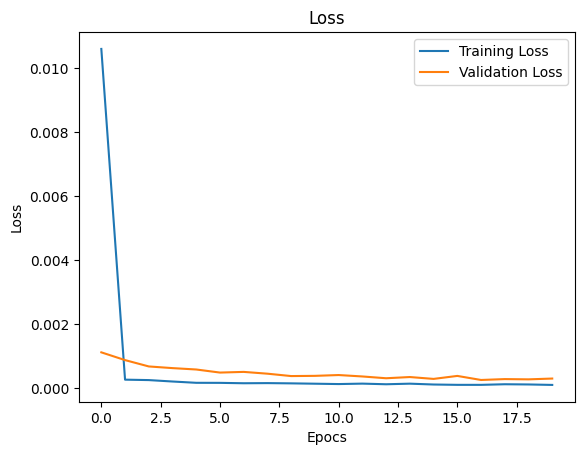

In [60]:
#Graph the Loss for training and validation to see if we have Overfitting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epocs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
#Prediction
prediction = model.predict(X_test)

#Transform the values from 0-1 range to original values
prediction = sc.inverse_transform(prediction)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [62]:
#Check features of prediction
print(type(prediction))
print(prediction.shape)
print(len(prediction))

#print(prediction)

<class 'numpy.ndarray'>
(629, 1)
629


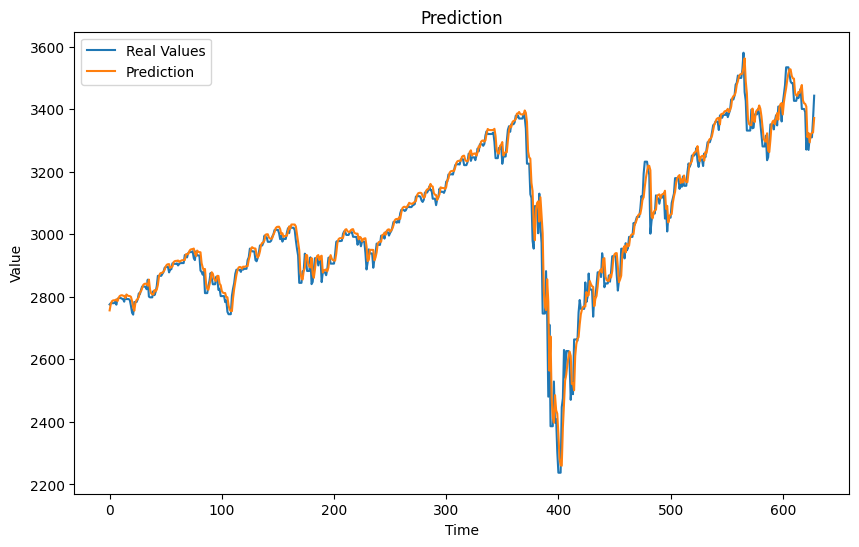

In [69]:
#Graph of the prediction
plt.figure(figsize=(10, 6))

set_testing_compare = set_testing['Close'].tolist()
plt.plot(set_testing_compare[45:], label='Real Values')
plt.plot(prediction, label='Prediction')

#Customize the graph
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
